<a href="https://colab.research.google.com/github/tobby-lie/transformer_chatbot_example/blob/main/Transformer_chatbot_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# This transformer chat bot is based on this notebook, with changes made to suit our use-case: https://blog.tensorflow.org/2019/05/transformer-chatbot-tutorial-with-tensorflow-2.html

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import sys

if 'google.colab' in sys.modules:
  %tensorflow_version 2.x
import tensorflow as tf

tf.random.set_seed(1234)
AUTO = tf.data.experimental.AUTOTUNE

#!pip install tensorflow-datasets==1.2.0
import tensorflow_datasets as tfds

import os
import re
import numpy as np
from time import time
import matplotlib.pyplot as plt

print("Tensorflow version {}".format(tf.__version__))

Tensorflow version 2.4.1


In [2]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


# GPU/TPU initialization

Select either TPU or GPU hardware accelerator in Google Colab

In [3]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU {}'.format(tpu.cluster_spec().as_dict()['worker']))
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy()

print("REPLICAS: {}".format(strategy.num_replicas_in_sync))

REPLICAS: 1


# Hyperparameters

In [4]:
# Maximum sentence length
MAX_LENGTH = 30

# For tf.data.Dataset
BATCH_SIZE = int(64 * strategy.num_replicas_in_sync)
BUFFER_SIZE = 20000

# For Transformer
NUM_LAYERS = 2 #6
D_MODEL = 256 #512
NUM_HEADS = 8
UNITS = 512 #2048
DROPOUT = 0.1

EPOCHS = 100

# The dataset is based on the Twitter conversational data which consists of 2-turn conversations

# We must extract conversation initiations as well as responses, remove special characters in the sentences, build a tokenizer to map text to ID and vice versa, tokenize each sentence as well as add start and end tokens

In [5]:
def textPreprocess(input_text):

  def removeAccents(input_text):
      strange='ąćęłńóśżź'
      ascii_replacements='acelnoszz'
      translator=str.maketrans(strange,ascii_replacements)
      return input_text.translate(translator)

  def removeSpecial(input_text):
      special='[^A-Za-z0-9 ]+'
      return re.sub(special, '', input_text)

  def removeTriplicated(input_text):
      return re.compile(r'(.)\1{2,}', re.IGNORECASE).sub(r'\1', input_text)

  return removeTriplicated(removeSpecial(removeAccents(input_text.lower())))

In [6]:
initiates = []
responses = []

with open('/content/drive/MyDrive/OSN_Project/data.txt', 'r', encoding="utf-8") as file:
    lines = file.readlines()
    for line in lines:
        if '|||' in line:
            initiates.append(line.split('|||')[0])
            responses.append(line.split('|||')[1])
#             print(line.split('|||'))

In [7]:
len(initiates)

155358

In [8]:
len(responses)

155358

In [9]:
print('Sample initiation: {}'.format(initiates[20]))
print("\n")
print('Sample response: {}'.format(responses[20]))

Sample initiation: congrats to you and to all of the virtual conference speakers . hopefully , we will still socialize in the evenings and mornings like irl . just think - - no long lines for the restrooms and elevators . 


Sample response:  thanks ! yes , i think some online socializing is a great idea - i will miss the dancing , tho !



In [10]:
text_preprocessor = lambda x: textPreprocess(x)

In [11]:
initiates_preprocessed = list(map(text_preprocessor, initiates))
responses_preprocessed = list(map(text_preprocessor, responses))

In [12]:
initiates_preprocessed[20]

'congrats to you and to all of the virtual conference speakers  hopefully  we will still socialize in the evenings and mornings like irl  just think no long lines for the restrooms and elevators  '

In [13]:
responses_preprocessed[20]

' thanks  yes  i think some online socializing is a great idea  i will miss the dancing  tho '

In [ ]:
# Build tokenizer using tfds for both questions and answers
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(
    initiates_preprocessed + responses_preprocessed, target_vocab_size=2**13)

# Define start and end token to indicate the start and end of a sentence
START_TOKEN, END_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size + 1]

# Vocabulary size plus start and end token
VOCAB_SIZE = tokenizer.vocab_size + 2

In [ ]:
print('Tokenized sample question: {}'.format(tokenizer.encode(initiates_preprocessed[20])))

In [ ]:
# Tokenize, filter and pad sentences
def tokenize_and_filter(inputs, outputs):
  tokenized_inputs, tokenized_outputs = [], []
  
  for (sentence1, sentence2) in zip(inputs, outputs):
    # tokenize sentence
    sentence1 = START_TOKEN + tokenizer.encode(sentence1) + END_TOKEN
    sentence2 = START_TOKEN + tokenizer.encode(sentence2) + END_TOKEN
    # check tokenized sentence max length
    if len(sentence1) <= MAX_LENGTH and len(sentence2) <= MAX_LENGTH:
      tokenized_inputs.append(sentence1)
      tokenized_outputs.append(sentence2)
  
  # pad tokenized sentences
  tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_inputs, maxlen=MAX_LENGTH, padding='post')
  tokenized_outputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_outputs, maxlen=MAX_LENGTH, padding='post')
  
  return tokenized_inputs, tokenized_outputs

In [ ]:
initiates_preprocessed, responses_preprocessed = tokenize_and_filter(initiates_preprocessed, responses_preprocessed)

In [ ]:
print('Vocab size: {}'.format(VOCAB_SIZE))
print('Number of samples: {}'.format(len(initiates_preprocessed)))

# We need to create the tf.data.Dataset in order to construct our input pipeline to utilize caching and prefetching to speed up the training process.

# The transformer is auto-regressive so it makes predictions one part at a time and uses its output at each time step to figure out what to do next. 

# During training, teacher-forcing is used. This is when we pass the true output to the next time step regardless of what the model predicts at the current time step.

# As the transformer predicts each word, self-attention allows it to look at the previous words in the input sequence to better predict the next word.

# In order to prevent the model from peaking at the expected output, the model uses a look-ahead mask. 

# Target is divided into decoder_inputs which padded as an input to the decoder and cropped_targets for calculating our loss and accuracy.

In [ ]:
# decoder inputs use the previous target as input
# remove START_TOKEN from targets
dataset = tf.data.Dataset.from_tensor_slices((
    {
        'inputs': initiates_preprocessed,
        'dec_inputs': responses_preprocessed[:, :-1]
    },
    {
        'outputs': responses_preprocessed[:, 1:]
    },
))

dataset = dataset.cache()
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

In [ ]:
print(dataset)

# Attention


---


# Scaled product Attention

The scaled dot-product attention function used by the transformer takes three inputs: Q (query), K (key), V (value). The equation used to calculate the attention weights is:

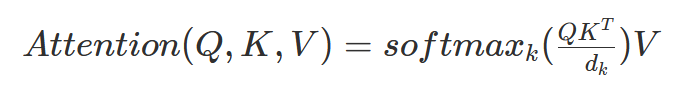

As the softmax normalization is done on the key, its values decide the amount of importance given to the query.

The output represents the multiplication of the attention weights and the value vector. This ensures that the words we want to focus on are kept as is and the irrelevant words are flushed out.

The dot-product attention is scaled by a factor of square root of the depth. This is done because for large values of depth, the dot product grows large in magnitude pushing the softmax function where it has small gradients resulting in a very hard softmax. 

For example, consider that query and key have a mean of 0 and variance of 1. Their matrix multiplication will have a mean of 0 and variance of dk. Hence, square root of dk is used for scaling (and not any other number) because the matmul of query and key should have a mean of 0 and variance of 1, so that we get a gentler softmax.

The mask is multiplied with -1e9 (close to negative infinity). This is done because the mask is summed with the scaled matrix multiplication of query and key and is applied immediately before a softmax. The goal is to zero out these cells, and large negative inputs to softmax are near zero in the output.

In [ ]:
def scaled_dot_product_attention(query, key, value, mask):
  """Calculate the attention weights. """
  matmul_qk = tf.matmul(query, key, transpose_b=True)

  # scale matmul_qk
  depth = tf.cast(tf.shape(key)[-1], tf.float32)
  logits = matmul_qk / tf.math.sqrt(depth)

  # add the mask to zero out padding tokens
  if mask is not None:
    logits += (mask * -1e9)

  # softmax is normalized on the last axis (seq_len_k)
  attention_weights = tf.nn.softmax(logits, axis=-1)

  output = tf.matmul(attention_weights, value)

  return output

In [ ]:
class MultiHeadAttention(tf.keras.layers.Layer):

  def __init__(self, d_model, num_heads, name="multi_head_attention"):
    super(MultiHeadAttention, self).__init__(name=name)
    self.num_heads = num_heads
    self.d_model = d_model

    assert d_model % self.num_heads == 0

    self.depth = d_model // self.num_heads

    self.query_dense = tf.keras.layers.Dense(units=d_model)
    self.key_dense = tf.keras.layers.Dense(units=d_model)
    self.value_dense = tf.keras.layers.Dense(units=d_model)

    self.dense = tf.keras.layers.Dense(units=d_model)

  def split_heads(self, inputs, batch_size):
    inputs = tf.reshape(
        inputs, shape=(batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(inputs, perm=[0, 2, 1, 3])

  def call(self, inputs):
    query, key, value, mask = inputs['query'], inputs['key'], inputs[
        'value'], inputs['mask']
    batch_size = tf.shape(query)[0]

    # linear layers
    query = self.query_dense(query)
    key = self.key_dense(key)
    value = self.value_dense(value)

    # split heads
    query = self.split_heads(query, batch_size)
    key = self.split_heads(key, batch_size)
    value = self.split_heads(value, batch_size)

    # scaled dot-product attention
    scaled_attention = scaled_dot_product_attention(query, key, value, mask)

    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

    # concatenation of heads
    concat_attention = tf.reshape(scaled_attention,
                                  (batch_size, -1, self.d_model))

    # final linear layer
    outputs = self.dense(concat_attention)

    return outputs

In [ ]:
def create_padding_mask(x):
  mask = tf.cast(tf.math.equal(x, 0), tf.float32)
  # (batch_size, 1, 1, sequence length)
  return mask[:, tf.newaxis, tf.newaxis, :]

In [ ]:
print(create_padding_mask(tf.constant([[1, 2, 0, 3, 0], [0, 0, 0, 4, 5]])))

In [ ]:
def create_look_ahead_mask(x):
  seq_len = tf.shape(x)[1]
  look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
  padding_mask = create_padding_mask(x)
  return tf.maximum(look_ahead_mask, padding_mask)

In [ ]:
print(create_look_ahead_mask(tf.constant([[1, 2, 0, 4, 5]])))

In [ ]:
class PositionalEncoding(tf.keras.layers.Layer):

  def __init__(self, position, d_model):
    super(PositionalEncoding, self).__init__()
    self.pos_encoding = self.positional_encoding(position, d_model)

  def get_angles(self, position, i, d_model):
    angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
    return position * angles

  def positional_encoding(self, position, d_model):
    angle_rads = self.get_angles(
        position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
        i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
        d_model=d_model)
    # apply sin to even index in the array
    sines = tf.math.sin(angle_rads[:, 0::2])
    # apply cos to odd index in the array
    cosines = tf.math.cos(angle_rads[:, 1::2])

    pos_encoding = tf.concat([sines, cosines], axis=-1)
    pos_encoding = pos_encoding[tf.newaxis, ...]
    return tf.cast(pos_encoding, tf.float32)

  def call(self, inputs):
    return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

In [ ]:
sample_pos_encoding = PositionalEncoding(50, 512)

plt.pcolormesh(sample_pos_encoding.pos_encoding.numpy()[0], cmap='RdBu')
plt.xlabel('Depth')
plt.xlim((0, 512))
plt.ylabel('Position')
plt.colorbar()
plt.show()

In [ ]:
def encoder_layer(units, d_model, num_heads, dropout, name="encoder_layer"):
  inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  attention = MultiHeadAttention(
      d_model, num_heads, name="attention")({
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': padding_mask
      })
  attention = tf.keras.layers.Dropout(rate=dropout)(attention)
  attention = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(inputs + attention)

  outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention + outputs)

  return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)

In [ ]:
def encoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name="encoder"):
  inputs = tf.keras.Input(shape=(None,), name="inputs")
  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
  embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))
  embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)
  for i in range(int(num_layers)):
    outputs = encoder_layer(
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
        name="encoder_layer_{}".format(i),
    )([outputs, padding_mask])

  return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)

In [ ]:
sample_encoder = encoder(
    vocab_size=8192,
    num_layers=2,
    units=512,
    d_model=128,
    num_heads=4,
    dropout=0.3,
    name="sample_encoder")

In [ ]:
def decoder_layer(units, d_model, num_heads, dropout, name="decoder_layer"):
  inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
  enc_outputs = tf.keras.Input(shape=(None, d_model), name="encoder_outputs")
  look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name="look_ahead_mask")
  padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

  attention1 = MultiHeadAttention(
      d_model, num_heads, name="attention_1")(inputs={
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': look_ahead_mask
      })
  attention1 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention1 + inputs)

  attention2 = MultiHeadAttention(
      d_model, num_heads, name="attention_2")(inputs={
          'query': attention1,
          'key': enc_outputs,
          'value': enc_outputs,
          'mask': padding_mask
      })
  attention2 = tf.keras.layers.Dropout(rate=dropout)(attention2)
  attention2 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention2 + attention1)

  outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention2)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(outputs + attention2)

  return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)

In [ ]:
sample_decoder_layer = decoder_layer(
    units=512,
    d_model=128,
    num_heads=4,
    dropout=0.3,
    name="sample_decoder_layer")

In [ ]:
def decoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name='decoder'):
  inputs = tf.keras.Input(shape=(None,), name='inputs')
  enc_outputs = tf.keras.Input(shape=(None, d_model), name='encoder_outputs')
  look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name='look_ahead_mask')
  padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')
  
  embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
  embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))
  embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  for i in range(int(num_layers)):
    outputs = decoder_layer(
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
        name='decoder_layer_{}'.format(i),
    )(inputs=[outputs, enc_outputs, look_ahead_mask, padding_mask])

  return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)

In [ ]:
def transformer(vocab_size,
                num_layers,
                units,
                d_model,
                num_heads,
                dropout,
                name="transformer"):
  inputs = tf.keras.Input(shape=(None,), name="inputs")
  dec_inputs = tf.keras.Input(shape=(None,), name="dec_inputs")

  enc_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='enc_padding_mask')(inputs)
  # mask the future tokens for decoder inputs at the 1st attention block
  look_ahead_mask = tf.keras.layers.Lambda(
      create_look_ahead_mask,
      output_shape=(1, None, None),
      name='look_ahead_mask')(dec_inputs)
  # mask the encoder outputs for the 2nd attention block
  dec_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='dec_padding_mask')(inputs)

  enc_outputs = encoder(
      vocab_size=vocab_size,
      num_layers=num_layers,
      units=units,
      d_model=d_model,
      num_heads=num_heads,
      dropout=dropout,
  )(inputs=[inputs, enc_padding_mask])

  dec_outputs = decoder(
      vocab_size=vocab_size,
      num_layers=num_layers,
      units=units,
      d_model=d_model,
      num_heads=num_heads,
      dropout=dropout,
  )(inputs=[dec_inputs, enc_outputs, look_ahead_mask, dec_padding_mask])

  outputs = tf.keras.layers.Dense(units=vocab_size, name="outputs")(dec_outputs)

  return tf.keras.Model(inputs=[inputs, dec_inputs], outputs=outputs, name=name)

In [ ]:
def loss_function(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  
  loss = tf.keras.losses.SparseCategoricalCrossentropy(
      from_logits=True, reduction='none')(y_true, y_pred)

  mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
  loss = tf.multiply(loss, mask)

  return tf.reduce_mean(loss)

In [ ]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):

  def __init__(self, d_model, warmup_steps=4000):
    super(CustomSchedule, self).__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps**-1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [ ]:
sample_learning_rate = CustomSchedule(d_model=128)

plt.plot(sample_learning_rate(tf.range(200000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

In [ ]:
 # clear backend
tf.keras.backend.clear_session()

learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

def accuracy(y_true, y_pred):
  # ensure labels have shape (batch_size, MAX_LENGTH - 1)
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

In [ ]:
# initialize and compile model within strategy scope
with strategy.scope():
  model = transformer(
      vocab_size=VOCAB_SIZE,
      num_layers=NUM_LAYERS,
      units=UNITS,
      d_model=D_MODEL,
      num_heads=NUM_HEADS,
      dropout=DROPOUT)

  model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])

model.summary()

In [ ]:
import datetime

#32% - 80 epok, po 30 epokach - 29

logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

model.fit(dataset, epochs=EPOCHS, callbacks = [tensorboard_callback])